In [22]:
import numpy as np

from data import *
from opt import *
from alternatives import ye_eusipco_18, segarra_tsp_17

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

# Parameters

In [23]:
N = 20
M = 100
p = 0.2
K = 3
sparsity = 2
eps_default = 0.1

x_model = "ones"# "bernoulli_gaussian"
p_x = 0.1

g_params_er = {
    'type': ER,
    'p': p
}
g_params_sw = {
    'type': SW,
    'k': 4,
    'p': 0.1
}
g_params = g_params_sw
p_n_def = 0.0

neg_coefs = False
exp_coefs = False
sort_h = True

n_graphs = 25

avg_fn = np.median

In [24]:
lambda_ = 0.01
beta = 0.001
alpha = 0.1
gamma = 1. #0.1
inc_gamma = 1.

params = (lambda_, beta, gamma, alpha, inc_gamma)

In [25]:
lambda_ = 0.001
beta = 0.0001
alpha = 0.01
gamma = 0.01 # 0.1
inc_gamma = 1.

params = (lambda_, beta, gamma, alpha, inc_gamma)

In [45]:
EXPS = [
    {
        'name': 'est_GXS',
        'color': 'b',
        'fmt': 'o-',
        'rew': True,
        'legend': 'RBD-G-rew'
    },
    {
        'name': 'est_GXS',
        'color': 'b',
        'fmt': 'o--',
        'rew': False,
        'legend': 'RBD-G'
    },
    {
        'name': 'est_HXS',
        'color': 'r',
        'fmt': 'd-',
        'rew': True,
        'legend': 'RBD-H-rew'
    },
    {
        'name': 'est_HXS',
        'color': 'r',
        'fmt': 'd--',
        'rew': False,
        'legend': 'RBD-H'
    },
    {
        'name': 'ye_eusipco_18',
        'color': 'g',
        'fmt': 's-',
        'legend': "Ye et al."
    }
]

# Methods

In [27]:
def calc_err(G_est, G_true, H_est, H_true, S_est, S_true, X_est, X_true):
    err_G = np.linalg.norm(G_est - G_true) / np.linalg.norm(G_true)
    err_H = np.linalg.norm(H_est - H_true) / np.linalg.norm(H_true)
    err_S = np.linalg.norm(S_est - S_true) / np.linalg.norm(S_true)
    err_X = np.linalg.norm(X_est - X_true) / np.linalg.norm(X_true)
    err_X = np.linalg.norm(X_est / np.linalg.norm(X_est) - X_true / np.linalg.norm(X_true))

    th_X = (X_est.max() - X_est.min()) / 2
    X_th = (X_est > th_X).astype(int)
    # s = np.count_nonzero(X_th[:,0])
    # if s == 0:
    #     s = 1
    # X_th = X_th / s

    err_X_th = np.linalg.norm(X_th - X_true) / np.linalg.norm(X_true)

    errs = {
        'err_G': err_G,
        'err_H': err_H,
        'err_S': err_S,
        'err_X': err_X,
        'err_X_th': err_X_th
    }
    return errs

def test(m, p_n, k, s, eps, params):
    X, Y, H, G, S, Sn, h = gen_data(N, m, g_params, p_n, eps, K=k, sparsity=s, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, x_model=x_model, p_x=p_x)
    G_true = G.copy()

    err_G, err_H, err_S, err_X, err_X_th = [np.zeros(len(EXPS)) for _ in range(5)]

    for i, exp in enumerate(EXPS):
        if exp['name'] == 'est_GXS':
            _, G_est, S_est, X_est = est_GXS(Y, Sn, params, max_iters=50, rew=exp['rew'], S_true=S, G_true=G, X_true=X, verbose=False)
            H_est = np.linalg.inv(G_est)
        elif exp['name'] == 'est_HXS':
            _, H_est, S_est, X_est = est_HXS(Y, Sn, params, max_iters=50, rew=exp['rew'], S_true=S, H_true=H, X_true=X, verbose=False)
            try:
                G_est = np.linalg.inv(H_est)
            except np.linalg.LinAlgError:
                print("H is Singular!")
                G_est = np.zeros(H_est.shape)
        elif exp['name'] == 'ye_eusipco_18':
            G_est, X_est = ye_eusipco_18(Sn, Y)
            S_est = Sn.copy()
            G_true = G / np.trace(G)
            H_est = np.linalg.inv(G_est)

        errs = calc_err(G_est, G_true, H_est, H, S_est, S, X_est, X)
        err_G[i], err_H[i], err_S[i], err_X[i], err_X_th[i] = \
            errs['err_G'], errs['err_H'], errs['err_S'], errs['err_X'], errs['err_X_th']

    return err_G, err_H, err_S, err_X, err_X_th

def objective(n_graphs, m, p_n, k, s, eps, params, avg_fn=np.mean):
    err_G, err_H, err_S, err_X, err_X_th = [np.zeros((n_graphs, len(EXPS))) for _ in range(5)]

    with Parallel(n_jobs=n_graphs) as parallel:

        funcs = []
        for i in range(n_graphs):
            funcs.append(delayed(test)(m, p_n, k, s, eps, params))
        
        results = parallel(funcs)

        for i in range(n_graphs):
            err_G[i,:], err_H[i,:], err_S[i,:], err_X[i,:], err_X_th[i,:] = results[i]

    return avg_fn(err_G, 0), avg_fn(err_H, 0), avg_fn(err_S, 0), avg_fn(err_X, 0), avg_fn(err_X_th, 0)

In [28]:
def plot_results(errs, x_ax, x_ax_name, y_axs_names, ylims, logys):
    assert len(errs) == len(ylims) == len(logys)
    plt.figure(figsize=(20,6))

    for i, err in enumerate(errs):

        plt.subplot(1, len(errs), i+1)
        for j, exp in enumerate(EXPS):
            if logys[i]:
                plt.semilogy(x_ax, err[:,j], exp['fmt'], color=exp['color'], label=exp['legend'])
            else:
                plt.plot(x_ax, err[:,j], exp['fmt'], color=exp['color'], label=exp['legend'])
        plt.title(y_axs_names[i])
        plt.xticks(x_ax, x_ax)
        plt.xlabel(x_ax_name)
        plt.ylabel("Normalized Error")
        plt.ylim(ylims[i])
    plt.legend([exp['legend'] for exp in EXPS])


In [65]:
def plot_single_figure(err, x_ax, x_ax_name, y_ax_name, save_name):
    plt.figure(figsize=(8,8))

    for j, exp in enumerate(EXPS):
        plt.semilogy(x_ax, err[:,j], exp['fmt'], color=exp['color'], label=exp['legend'])

    plt.xlabel(x_ax_name, fontsize=18)
    plt.ylabel(y_ax_name, fontsize=18)

    plt.xticks(x_ax, fontsize=16)
    plt.yticks(fontsize=16)

    plt.legend(fontsize=18)
    plt.savefig(f'results_ICASSP24/{save_name}.eps')

In [70]:
def results_to_csv(err, x_ax, x_ax_name, save_name):
    f = open(f'results_ICASSP24/{save_name}.csv', 'w')
    f.write(','.join([x_ax_name] + [exp['legend'] for exp in EXPS]) + '\n')
    for i, x in enumerate(x_ax):
        f.write(','.join([str(x)] + [str(err[i,j]) for j in range(len(EXPS))]) + '\n')
    f.close()

# Experiments

## Modifying graph perturbation

In [29]:
eps_vals = [0., 0.03, 0.05, 0.1, 0.15, 0.2, 0.25]

errs_G_pert, errs_H_pert, errs_S_pert, errs_X_pert, errs_X_th_pert = [np.zeros((len(eps_vals), len(EXPS))) for _ in range(5)]

for i, eps in enumerate(eps_vals):
    print(f"Starting {eps=}", flush=True)
    errs_G_pert[i,:], errs_H_pert[i,:], errs_S_pert[i,:], errs_X_pert[i,:], errs_X_th_pert[i,:] = objective(n_graphs, M, p_n_def, K, sparsity, eps, params, avg_fn=avg_fn)

Starting eps=0.0


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting eps=0.03


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting eps=0.05
Starting eps=0.1


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting eps=0.15
Starting eps=0.2
Starting eps=0.25


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/tmp/ipykernel_24761/4143928864.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylims[i])


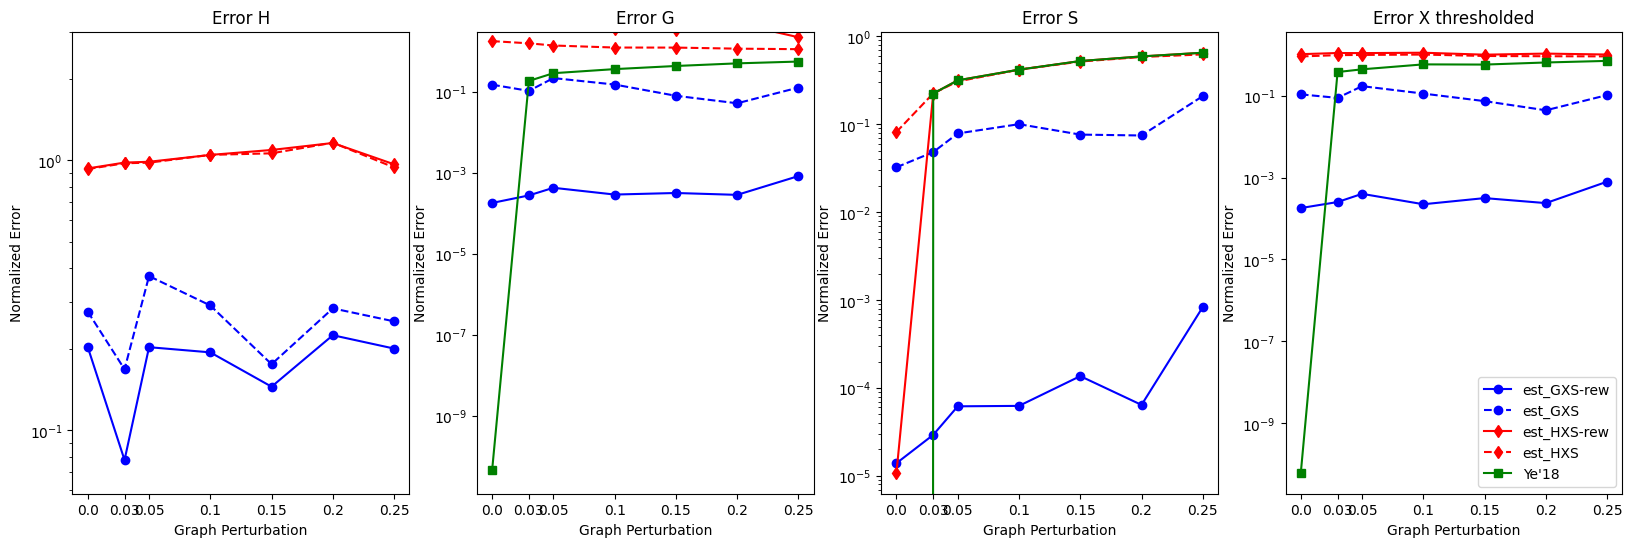

In [30]:
plot_results([errs_H_pert, errs_G_pert, errs_S_pert, errs_X_pert], eps_vals, "Graph Perturbation", ["Error H", "Error G", "Error S", "Error X thresholded"], ylims=[(0,3), (0,3), (None, None), (None, None)], logys=[True, True, True, True])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


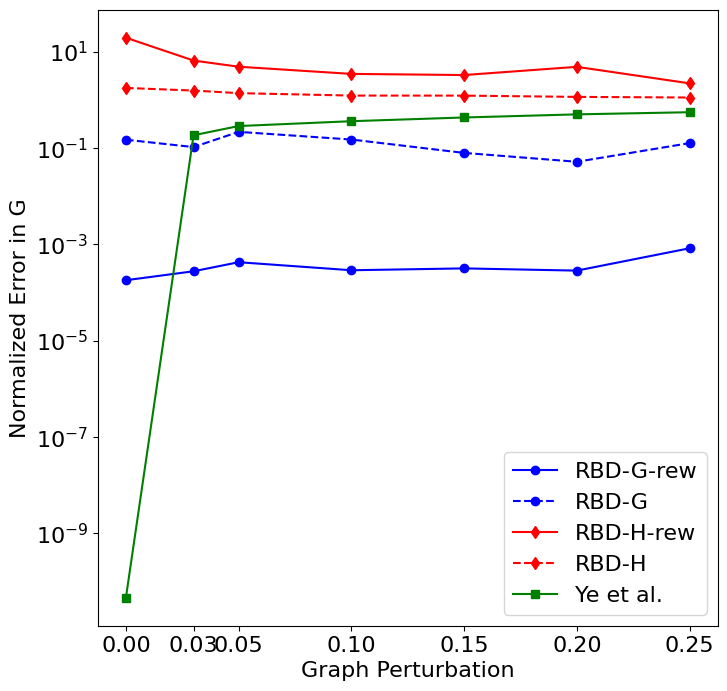

In [64]:
plot_single_figure(errs_G_pert, eps_vals, "Graph Perturbation", "Normalized Error in G", "err_G_pert")

In [71]:
results_to_csv(errs_G_pert, eps_vals, "Eps", "err_G_pert")

## Modifying X sparsity

In [31]:
S_vals = [2, 3, 4, 5, 6]

errs_G_sparsity, errs_H_sparsity, errs_S_sparsity, errs_X_sparsity, errs_X_th_sparsity = [np.zeros((len(S_vals), len(EXPS))) for _ in range(5)]

for i, s in enumerate(S_vals):
    print(f"Starting {s=}", flush=True)
    errs_G_sparsity[i,:], errs_H_sparsity[i,:], errs_S_sparsity[i,:], errs_X_sparsity[i,:], errs_X_th_sparsity[i,:] = objective(n_graphs, M, p_n_def, K, s, eps_default, params, avg_fn=avg_fn)

Starting s=2


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting s=3
Starting s=4


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting s=5
Starting s=6


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/tmp/ipykernel_24761/4143928864.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylims[i])


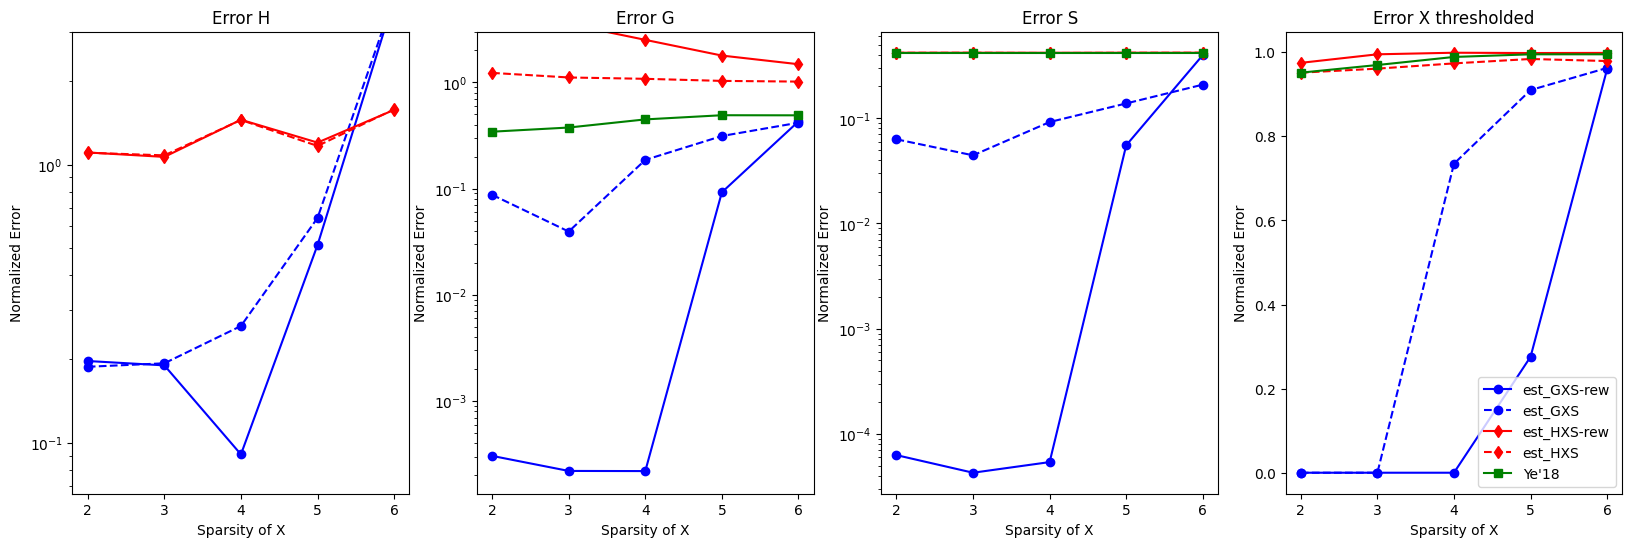

In [32]:
plot_results([errs_H_sparsity, errs_G_sparsity, errs_S_sparsity, errs_X_th_sparsity], S_vals, "Sparsity of X", ["Error H", "Error G", "Error S", "Error X thresholded"], ylims=[(0,3), (0,3), (None, None), (None, None)], logys=[True, True, True, False])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


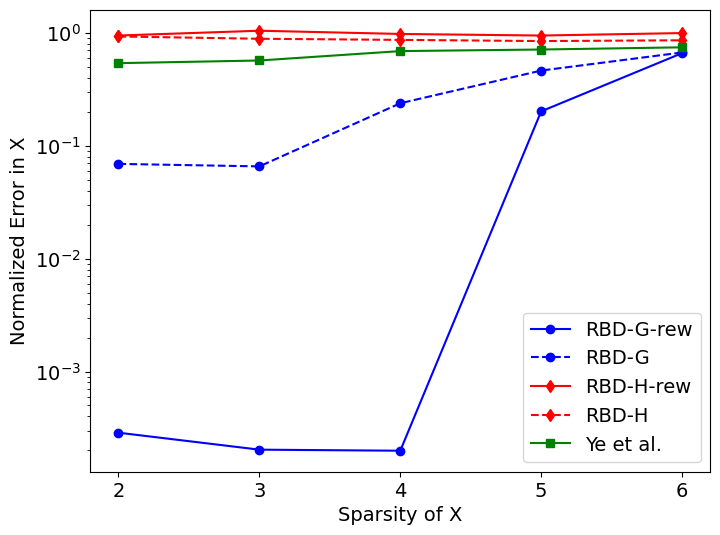

In [51]:
plt.figure(figsize=(8,6))

for j, exp in enumerate(EXPS):
    plt.semilogy(S_vals, errs_X_sparsity[:,j], exp['fmt'], color=exp['color'], label=exp['legend'])

plt.xlabel("Sparsity of X", fontsize=14)
plt.ylabel("Normalized Error in X", fontsize=14)

plt.xticks(S_vals, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.savefig('results_ICASSP24/err_X_sparsity.eps')

In [58]:
results_to_csv(errs_X_sparsity, S_vals, "S", "err_X_sparsity")

## Modifying Filter Order

In [33]:
K_vals = [2, 3, 4, 5, 6]

errs_G_order, errs_H_order, errs_S_order, errs_X_order, errs_X_th_order = [np.zeros((len(K_vals), len(EXPS))) for _ in range(5)]

for i, k in enumerate(K_vals):
    print(f"Starting {k=}", flush=True)
    errs_G_order[i,:], errs_H_order[i,:], errs_S_order[i,:], errs_X_order[i,:], errs_X_th_order[i,:] = objective(n_graphs, M, p_n_def, k, sparsity, eps_default, params, avg_fn=avg_fn)

Starting k=2


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting k=3


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting k=4


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: 

Starting k=5
Starting k=6


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


S is None
S is None
S is None
S is None
S is None
S is None
S is None
S is None
S is None
S is None
S is None
S is None


/tmp/ipykernel_24761/4143928864.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylims[i])


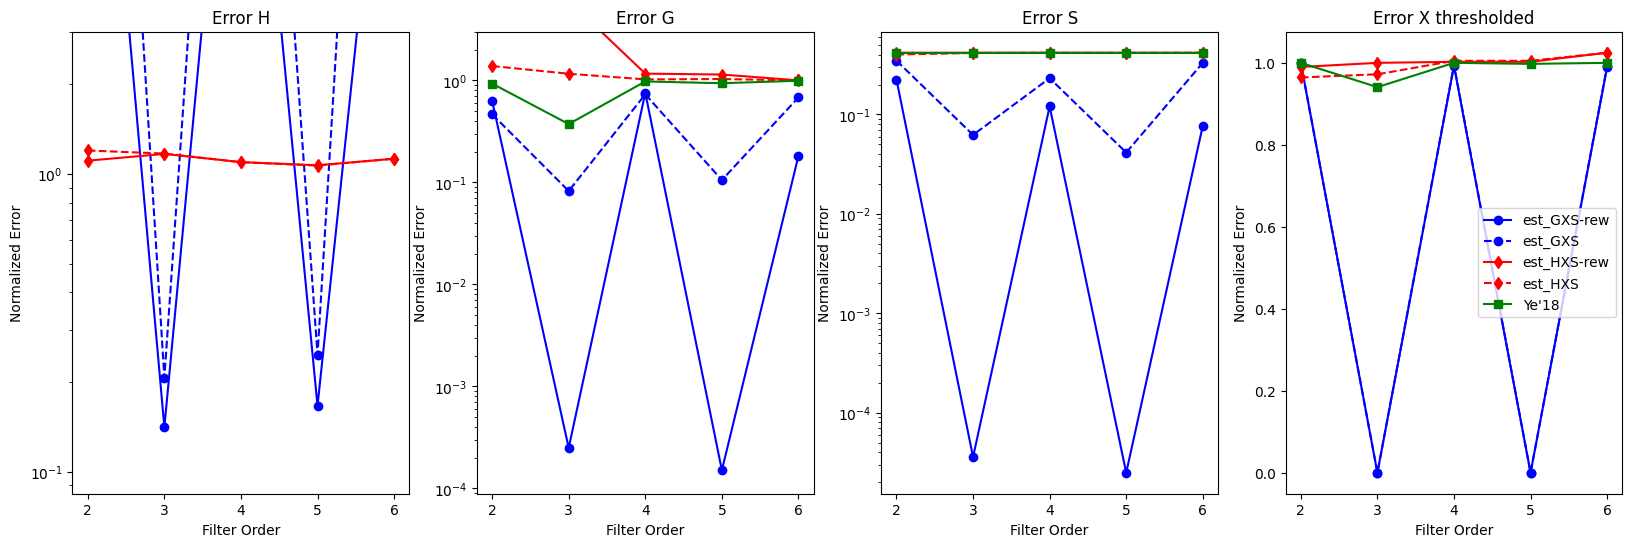

In [34]:
plot_results([errs_H_order, errs_G_order, errs_S_order, errs_X_th_order], K_vals, "Filter Order", ["Error H", "Error G", "Error S", "Error X thresholded"], ylims=[(0,3), (0,3), (None, None), (None, None)], logys=[True, True, True, False])

## Modifying Number of Samples

In [39]:
M_vals = [15, 20, 30, 50, 100]

errs_G_samp, errs_H_samp, errs_S_samp, errs_X_samp, errs_X_th_samp = [np.zeros((len(M_vals), len(EXPS))) for _ in range(5)]

for i, m in enumerate(M_vals):
    print(f"Starting {m=}", flush=True)
    errs_G_samp[i,:], errs_H_samp[i,:], errs_S_samp[i,:], errs_X_samp[i,:], errs_X_th_samp[i,:] = objective(n_graphs, m, p_n_def, K, sparsity, eps_default, params, avg_fn=avg_fn)

Starting m=15


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


S is None


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting m=20


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting m=30


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: 

Starting m=50


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Starting m=100


/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


/tmp/ipykernel_24761/4143928864.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylims[i])


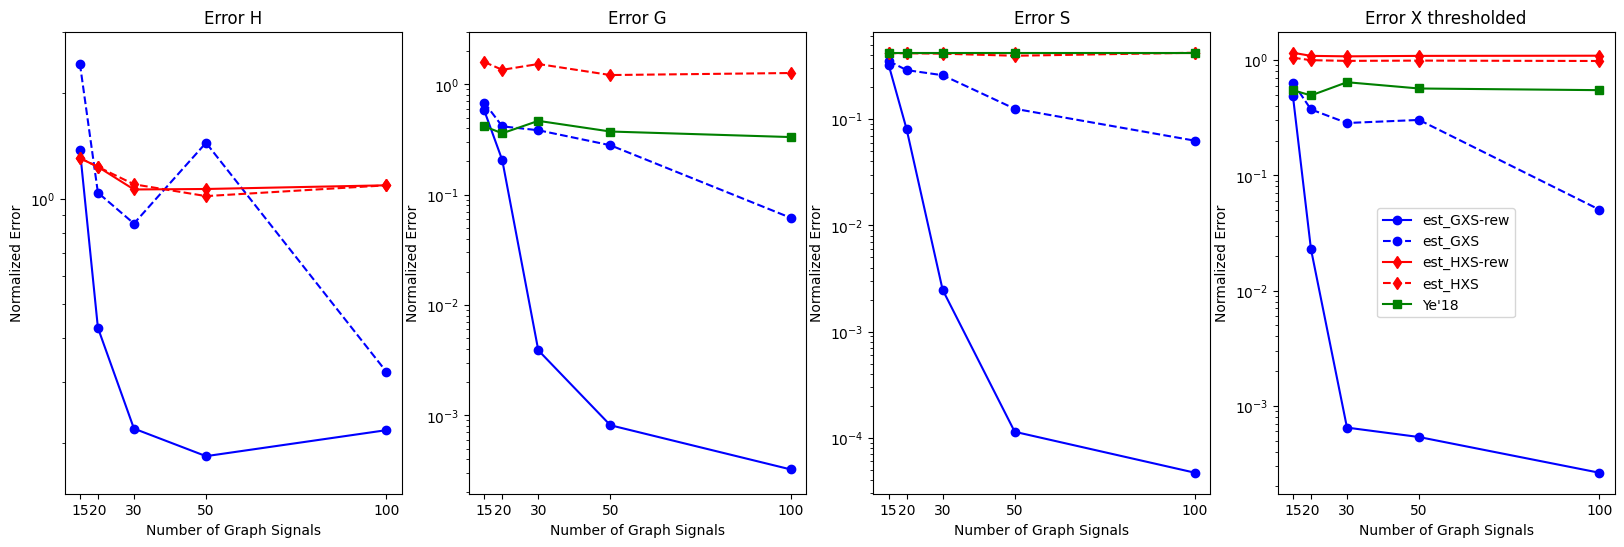

In [40]:
plot_results([errs_H_samp, errs_G_samp, errs_S_samp, errs_X_samp], M_vals, "Number of Graph Signals", ["Error H", "Error G", "Error S", "Error X thresholded"], ylims=[(0,3), (0,3), (None, None), (None, None)], logys=[True, True, True, True])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


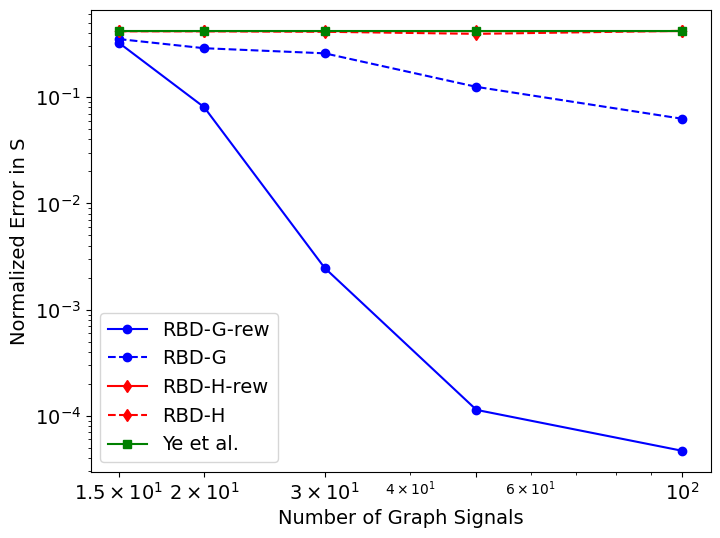

In [50]:
plt.figure(figsize=(8,6))

for j, exp in enumerate(EXPS):
    plt.loglog(M_vals, errs_S_samp[:,j], exp['fmt'], color=exp['color'], label=exp['legend'])

plt.xlabel("Number of Graph Signals", fontsize=14)
plt.ylabel("Normalized Error in S", fontsize=14)

plt.xticks(M_vals, fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)
plt.savefig('results_ICASSP24/err_S_samp.eps')

In [60]:
results_to_csv(errs_S_samp, M_vals, "M", "err_S_samp")

# Samples + Noise

In [37]:
import pandas as pd

In [38]:
M_vals_n = [15, 50]
p_n_vals_n = [0., 0.02]

errs_G_sampnoise, errs_H_sampnoise, errs_S_sampnoise, errs_X_sampnoise, errs_X_th_sampnoise = [np.zeros((len(EXPS), len(M_vals), len(p_n_vals))) for _ in range(5)]

for i, m in enumerate(M_vals_n):
    for j, p_n in enumerate(p_n_vals_n):
        print(f"Starting {m=} {p_n=}", flush=True)
        errs_G_sampnoise[:,i,j], errs_H_sampnoise[:,i,j], errs_S_sampnoise[:,i,j], errs_X_sampnoise[:,i,j], errs_X_th_sampnoise[:,i,j] = objective(n_graphs, m, p_n, K, sparsity, eps_default, params, avg_fn=avg_fn)

Starting m=15 p_n=0.0


KeyboardInterrupt: 

In [ ]:
columns = pd.MultiIndex.from_product((M_vals_n, p_n_vals_n), names=['M', 'Noise power'])

table = pd.DataFrame(errs_G_sampnoise.reshape(len(EXPS),-1), columns=columns, index=[exp['legend'] for exp in EXPS])
table

M                  15                  50          
Noise power      0.00      0.02      0.00      0.02
est_GXS-rew  0.745977  0.706553  0.000999  0.433760
est_GXS      0.688117  0.706553  0.387531  0.433760
est_HXS-rew  4.454372  4.426449  3.594842  4.766259
est_HXS      1.483954  1.389087  1.297902  1.184320
Ye'18        0.447493  0.325610  0.373868  0.327012

In [ ]:
table = pd.DataFrame(errs_X_th_sampnoise.reshape(len(EXPS),-1), columns=columns, index=[exp['legend'] for exp in EXPS])
table

M                  15                  50          
Noise power      0.00      0.02      0.00      0.02
est_GXS-rew  0.658281  0.930949  0.000000  0.959166
est_GXS      0.894427  0.930949  0.994987  0.959166
est_HXS-rew  1.016530  1.016530  1.000000  0.989949
est_HXS      1.000000  1.032796  0.964365  0.964365
Ye'18        0.875595  0.730297  0.916515  0.932738